# Getting the Data

The best place we found for large-scale datasets of NBA player stats was NBA.com. However, it is paywalled/heavily limited in terms of access without a prior letter to their office, which we could not feasibly do. So, after some digging, we found the NBA_API github, which thankfully did have back-end access to the dataset we wanted to get. Right under this, are the 2 Colab Installations for nba_api(which is the aforementioned github repo), and tqdm, which is a progress bar that we used to track the progress of the download of the dataset.

In [ ]:
#installation of api access and tqdm for progress bar
!pip install nba_api
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.7/261.7 kB 2.1 MB/s eta 0:00:00


# Accessing the API

Once we installed the 2 packages, we then imported the playercareerstats and static players.py datasets, pandas for data manipulation, tqdm to serve as a progress bar, and ReadTimeout to let us know if there were any issues with getting all of the data from the API. Then, we saved the end dataframe to a csv.

In [ ]:
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.static import players
import pandas as pd
from tqdm import tqdm
from requests.exceptions import ReadTimeout


#obtaining data from nba_api, standard json access and conversion code
def fetch_player_career_stats(player_id, timeout=None):
    max_retries = 3
    retries = 0
    while retries < max_retries:
        try:
            player_career = playercareerstats.PlayerCareerStats(
                player_id=player_id,
                timeout=timeout
            )
            return player_career.get_data_frames()[0]
        except ReadTimeout as e:
            retries += 1
            print(f"Read timeout. Retrying... (Attempt {retries}/{max_retries})")
    raise Exception("Failed to fetch data after multiple retries.")

# Timeout
timeout = 100

# Get all players
all_players = players.get_players()

# Initialize an empty list to store player dfs
career_dfs = []

# using tqdm to measure conversion process
for player in tqdm(all_players, desc="Processing Players"):
    player_id = player['id']

    # Get player career stats with custom settings
    try:
        career_df = fetch_player_career_stats(
            player_id=player_id,
            timeout=timeout
        )
    except Exception as e:
        print(f"Error fetching data for Player ID {player_id}: {e}")
        continue

    # make sure df is applicable for our criteria of 5 Y period
    if any((career_df['SEASON_ID'] >= '2018') & (career_df['SEASON_ID'] <= '2023')):

        # Filter df for 2018-2023
        mask = (career_df['SEASON_ID'] >= '2018') & (career_df['SEASON_ID'] <= '2023')
        career_df_filtered = career_df.loc[mask].copy()

        # Add player to df
        career_df_filtered['Player_ID'] = player_id
        career_df_filtered['Player_Name'] = player['full_name']

        # Append df to the list
        career_dfs.append(career_df_filtered)

#combining all dfs
all_players_df = pd.concat(career_dfs, ignore_index=True)

#saving to csv
all_players_df.to_csv('all_players_career_stats_2018_2023.csv', index=False)

# Feature Selection
After downloading the csv of player stats (it was a json but we converted it so we could easier integrate it with pandas), we ran some basic statistical tests on the numeric variables (since there were only 5 years anyway, so things like player name and years played would have a negative effect on the efficacy of the model). The goal here was to determine which values had the highest correlation to Assists, which were our value we were trying to predict.

In [ ]:
import pandas as pd

all_players_df = pd.read_csv("/content/all_players_career_stats_2018_2023.csv")
all_players_df.head()

# Assuming your target variable is 'AST'
target_variable = 'AST'

# Calculate correlations with the target variable
correlations = all_players_df.corr()[target_variable].abs().sort_values(ascending=False)

# Print the top correlated features
print("Top Correlated Features:")
print(correlations.head(8))

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Calculate correlations with the target variable
correlations = all_players_df.corr()['AST'].abs().sort_values(ascending=False)

# Select the top 8 correlated features
selected_features = correlations.index[1:9]  # Excluding the target variable

# Extract features and target
X = all_players_df[selected_features]
y = all_players_df['AST'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Initialize RFE
rfe = RFE(model, n_features_to_select=8)  # Set the number of features you want to select

# Fit RFE on the training data
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Get the selected features
selected_features_rfe = X.columns[rfe.support_]

# Print the selected features
print("Top 8 Correlated Features:", selected_features_rfe)


# Training the 1st Iteration of the Model
After finding the top 8 correlated features, we now knew what to target in our model. This was the most complicated portion of our process. We did not know whether we wanted to use a simple pass-forward Neural Network, or use some other sort of Machine Learning Algorithm. Eventually, we compared Random Forest Classification, a simple forward-feeding CNN, and a LSTM-Based RNN. We found that of the 3, the RNN had by far the most efficacy in reducing loss (MSE) and variance (R-Squared) (most likely due to the complexity of the model).

Epoch 1/1000
72/72 [==============================] - 3s 8ms/step - loss: 19608.2266 - mean_squared_error: 19608.2266 - val_loss: 18974.7070 - val_mean_squared_error: 18974.7070
Epoch 2/1000
72/72 [==============================] - 0s 4ms/step - loss: 15866.5283 - mean_squared_error: 15866.5283 - val_loss: 10601.8252 - val_mean_squared_error: 10601.8252
Epoch 3/1000
72/72 [==============================] - 0s 4ms/step - loss: 6397.2148 - mean_squared_error: 6397.2148 - val_loss: 3433.0215 - val_mean_squared_error: 3433.0215
Epoch 4/1000
72/72 [==============================] - 0s 4ms/step - loss: 3657.9138 - mean_squared_error: 3657.9138 - val_loss: 3026.6826 - val_mean_squared_error: 3026.6826
Epoch 5/1000
72/72 [==============================] - 0s 4ms/step - loss: 3216.7893 - mean_squared_error: 3216.7893 - val_loss: 2721.7397 - val_mean_squared_error: 2721.7397
Epoch 6/1000
72/72 [==============================] - 0s 4ms/step - loss: 2974.5237 - mean_squared_error: 2974.5237 - val_

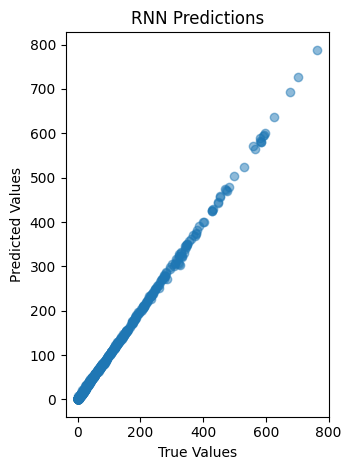

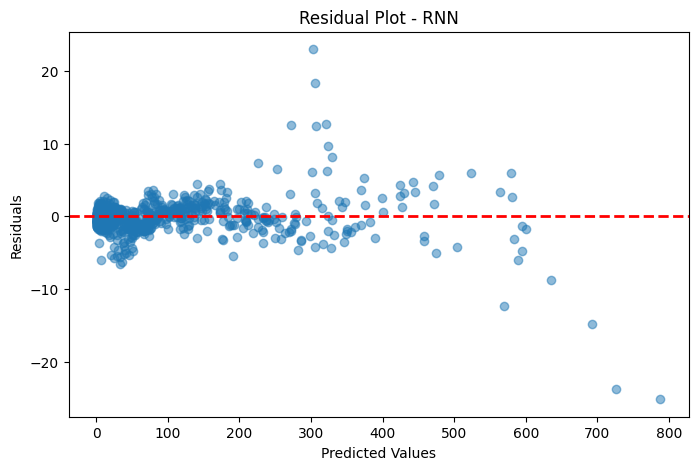

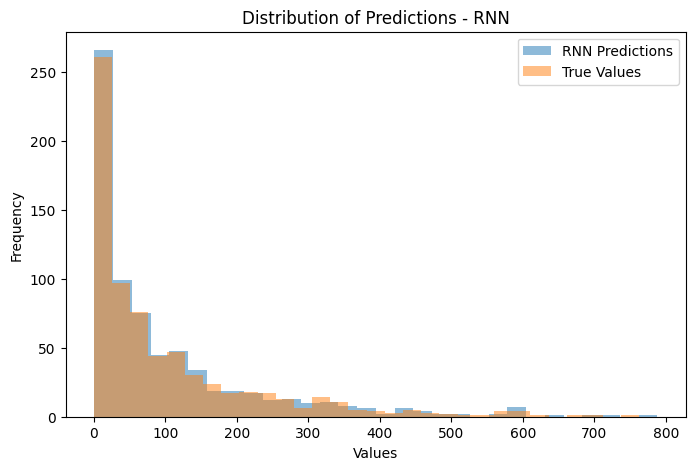

Epoch 1/1000
68/68 [==============================] - 3s 10ms/step - loss: 12448.7930 - mean_squared_error: 12448.7930 - val_loss: 12606.9551 - val_mean_squared_error: 12606.9551
Epoch 2/1000
68/68 [==============================] - 1s 8ms/step - loss: 9403.3057 - mean_squared_error: 9403.3057 - val_loss: 5796.8184 - val_mean_squared_error: 5796.8184
Epoch 3/1000
68/68 [==============================] - 0s 7ms/step - loss: 3122.7153 - mean_squared_error: 3122.7153 - val_loss: 2336.6812 - val_mean_squared_error: 2336.6812
Epoch 4/1000
68/68 [==============================] - 0s 7ms/step - loss: 2372.7422 - mean_squared_error: 2372.7422 - val_loss: 2207.2888 - val_mean_squared_error: 2207.2888
Epoch 5/1000
68/68 [==============================] - 0s 5ms/step - loss: 2195.2969 - mean_squared_error: 2195.2969 - val_loss: 2063.2947 - val_mean_squared_error: 2063.2947
Epoch 6/1000
68/68 [==============================] - 0s 4ms/step - loss: 2043.8773 - mean_squared_error: 2043.8773 - val_los

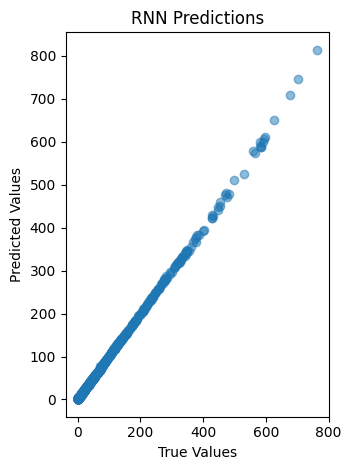

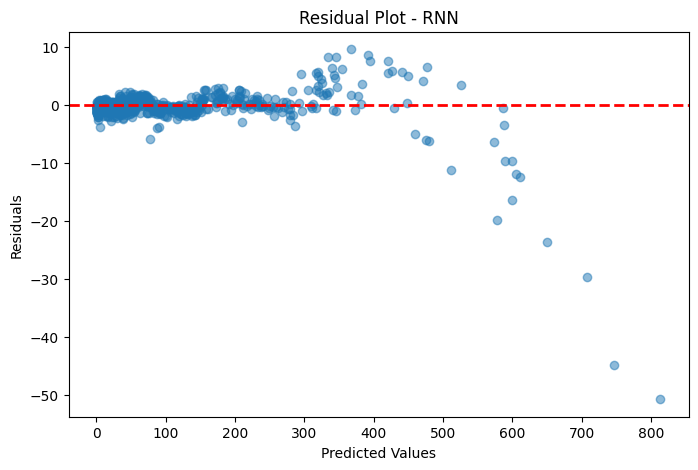

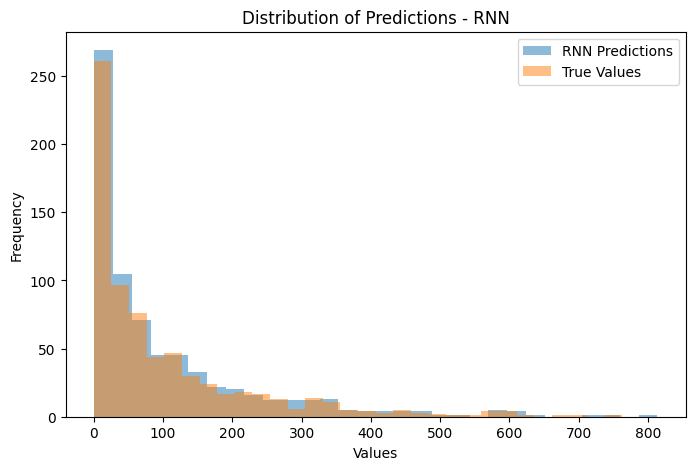

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                21504     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23617 (92.25 KB)
Trainable params: 23617 (92.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

TypeError: Cannot clone object '<keras.src.engine.sequential.Sequential object at 0x7ff22d072dd0>' (type <class 'keras.src.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# Constants
FILE_PATH = '/content/all_players_career_stats_2013_2023.csv'
FEATURES = ['FG3A', 'FGA', 'FTA', 'STL', 'TOV', 'PTS']
TARGET = 'AST'
SEED = 42

# Set seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data
def load_data(file_path):
    return pd.read_csv('/content/all_players_career_stats_2018_2023.csv')

# Preprocess data
def preprocess_data(data):
    # Feature engineering
    data['PTS'] = data['PTS'] / data['GP']
    data = data.dropna(subset=FEATURES + [TARGET])
    api_data_array = winsorize(data[FEATURES].values, limits=[0.01, 0.01], axis=0)
    data[FEATURES] = pd.DataFrame(api_data_array, columns=FEATURES)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(data[FEATURES])
    poly_feature_names = poly.get_feature_names_out(FEATURES)
    data_poly = pd.DataFrame(X_poly, columns=poly_feature_names)
    power_transformer = PowerTransformer()
    X_power = power_transformer.fit_transform(data[FEATURES])
    data_power = pd.DataFrame(X_power, columns=FEATURES)
    data = pd.concat([data, data_poly, data_power], axis=1)

    # Prepare data
    exclude_columns = [col for col in data.columns if col not in (FEATURES + [TARGET])]
    X = data.drop(columns=exclude_columns)
    y = data[TARGET].values

    # Standardization using Min-Max Scaling
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return train_test_split(X_scaled, y, test_size=0.2, random_state=SEED)

# Create RNN model
def create_rnn_model(input_shape):
    model = keras.Sequential([
        layers.LSTM(64, activation='relu', input_shape=(None, input_shape)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    return model

# Train RNN model
def train_rnn_model(model, X_train, y_train, epochs=1000, batch_size=32, callbacks=None):
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    # Combine user-provided callbacks with early stopping
    all_callbacks = [early_stopping] if callbacks is None else [early_stopping] + callbacks

    # Reshape input for sequence modeling
    X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

    # Train the model with combined callbacks
    model.fit(
        X_train_reshaped, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_split=0.2,
        callbacks=all_callbacks
    )

# Evaluate RNN model
def evaluate_rnn_model(model, X_test, y_test):
    # Reshape input for sequence modeling
    X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    rnn_pred = model.predict(X_test_reshaped)
    rnn_mse = mean_squared_error(y_test, rnn_pred)
    rnn_rmse = np.sqrt(rnn_mse)
    rnn_mae = mean_absolute_error(y_test, rnn_pred)
    rnn_r2 = r2_score(y_test, rnn_pred)
    return rnn_pred, rnn_mse, rnn_rmse, rnn_mae, rnn_r2

# Plot results
def plot_results_rnn(y_true, y_pred, residual):
    # Scatter Plot for RNN Predictions
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred.flatten(), alpha=0.5)
    plt.title('RNN Predictions')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.tight_layout()

    # Residual Plot for RNN
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred.flatten(), residual, alpha=0.5)
    plt.title('Residual Plot - RNN')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.show()

    # Distribution of Predictions for RNN
    plt.figure(figsize=(8, 5))
    plt.hist(y_pred.flatten(), bins=30, alpha=0.5, label='RNN Predictions')
    plt.hist(y_true, bins=30, alpha=0.5, label='True Values')
    plt.title('Distribution of Predictions - RNN')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Main script
if __name__ == "__main__":
    api_data = load_data(FILE_PATH)
    X_train, X_test, y_train, y_test = preprocess_data(api_data)

    # Apply Isolation Forest to identify and potentially remove outliers from the training data
    iso_forest = IsolationForest(contamination=0.05, random_state=SEED)
    outlier_labels = iso_forest.fit_predict(X_train)
    outlier_indices = np.where(outlier_labels == -1)[0]
    X_train_no_outliers = np.delete(X_train, outlier_indices, axis=0)
    y_train_no_outliers = np.delete(y_train, outlier_indices)

    # Train the RNN model with outliers
    rnn_model_with_outliers = create_rnn_model(X_train.shape[1])
    train_rnn_model(rnn_model_with_outliers, X_train, y_train)

    # Evaluate the model on the test set with outliers
    rnn_pred_with_outliers, rnn_mse_with_outliers, rnn_rmse_with_outliers, rnn_mae_with_outliers, rnn_r2_with_outliers = evaluate_rnn_model(rnn_model_with_outliers, X_test, y_test)

    # Print or use the evaluation metrics for the model with outliers
    print("\nRNN Model Metrics with Outliers:")
    print("MSE:", rnn_mse_with_outliers)
    print("RMSE:", rnn_rmse_with_outliers)
    print("MAE:", rnn_mae_with_outliers)
    print("R-squared:", rnn_r2_with_outliers)

    # Plot results for the model with outliers
    plot_results_rnn(y_test, rnn_pred_with_outliers.flatten(), y_test - rnn_pred_with_outliers.flatten())

    # Train the RNN model without outliers
    rnn_model_no_outliers = create_rnn_model(X_train_no_outliers.shape[1])
    train_rnn_model(rnn_model_no_outliers, X_train_no_outliers, y_train_no_outliers)

    # Evaluate the model on the test set without outliers
    rnn_pred_no_outliers, rnn_mse_no_outliers, rnn_rmse_no_outliers, rnn_mae_no_outliers, rnn_r2_no_outliers = evaluate_rnn_model(rnn_model_no_outliers, X_test, y_test)

    # Print or use the evaluation metrics for the model without outliers
    print("\nRNN Model Metrics without Outliers:")
    print("MSE:", rnn_mse_no_outliers)
    print("RMSE:", rnn_rmse_no_outliers)
    print("MAE:", rnn_mae_no_outliers)
    print("R-squared:", rnn_r2_no_outliers)

    # Plot results for the model without outliers
    plot_results_rnn(y_test, rnn_pred_no_outliers.flatten(), y_test - rnn_pred_no_outliers.flatten())

    # RNN Model Summary
    rnn_model_with_outliers.summary()
    rnn_model_no_outliers.summary()

    # Organize code into functions for different tasks
def isolation_forest_outlier_removal(X_train, contamination=0.05):
    iso_forest = IsolationForest(contamination=contamination, random_state=SEED)
    outlier_labels = iso_forest.fit_predict(X_train)
    outlier_indices = np.where(outlier_labels == -1)[0]
    X_train_no_outliers = np.delete(X_train, outlier_indices, axis=0)
    return X_train_no_outliers

# Visualize the LSTM model architecture
def visualize_model_architecture(model):
    from tensorflow.keras.utils import plot_model
    plot_model(model, show_shapes=True, show_layer_names=True)

# Explore other outlier detection techniques
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope

def visualize_outlier_detection(X_train):
    # Standardize the data
    X_train_std = StandardScaler().fit_transform(X_train)

    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train_std)

    # Apply Elliptic Envelope for outlier detection
    envelope = EllipticEnvelope(contamination=0.05)
    outliers = envelope.fit_predict(X_train_std)

    # Visualize the results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=outliers, cmap='viridis', alpha=0.8)
    plt.title('Outlier Detection using Elliptic Envelope')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Visualize the LSTM model architecture
visualize_model_architecture(rnn_model_with_outliers)

# Explore other regression metrics
from sklearn.metrics import median_absolute_error

median_absolute_err = median_absolute_error(y_test, rnn_pred_with_outliers)
print("Median Absolute Error:", median_absolute_err)

# Plot learning curves
def plot_learning_curves(model, X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    train_mean = -np.mean(train_scores, axis=1)
    test_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training error')
    plt.plot(train_sizes, test_mean, label='Validation error')
    plt.title('Learning Curves')
    plt.xlabel('Training Examples')
    plt.ylabel('Negative Mean Squared Error')
    plt.legend()
    plt.show()

# Plot learning curves for the RNN model
plot_learning_curves(rnn_model_with_outliers, X_train, y_train)

# Explore hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {'units': [32, 64, 128], 'dropout_rate': [0.2, 0.3, 0.4]}
grid_search = GridSearchCV(create_rnn_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model for evaluation
best_rnn_model = grid_search.best_estimator_
best_rnn_pred, best_rnn_mse, best_rnn_rmse, best_rnn_mae, best_rnn_r2 = evaluate_rnn_model(best_rnn_model, X_test, y_test)
print("\nBest RNN Model Metrics:")
print("MSE:", best_rnn_mse)
print("RMSE:", best_rnn_rmse)
print("MAE:", best_rnn_mae)
print("R-squared:", best_rnn_r2)


# On Convergence, or "How do I know you aren't just bullshitting me?"

**Convergence**, refers to the process by which the **parameters** (internal variables derived purely from data) of a model gradually reach a stable and “optimal” state. It indicates that the algorithm has


1.   Effectively minimized the chosen **objective function**, such as a **loss function**

2.   Learned the underlying patterns in the training data

3.   Can predict with a relative sense of accuracy future data given to it

In the training of machine learning models like ours, convergence is achieved when the algorithm iteratively updates the model parameters, adjusting them to minimize the difference between the predicted output and the actual target values. The process typically involves an optimization algorithm, such as Stochastic Gradient Descent (**SGD**) or variants like **ADAM** and **RMSprop** (and their derivatives, **Adadelta** and **adagrad**). Different optimization functions are used depending on data and other factors, so below is a brief overview of some, their applicabilities, and an eventual justification for the use of the ADAM function in our model. The loss function measures how well the model’s predictions match the true target values. It is a mathematical function that takes the model’s predictions and the true values as input and outputs a single scalar value representingthe “error” or “loss.”. The gradient is a vector containing the partial derivatives of the loss function withrespect to each model parameter.

Mathematically, for a model with parameters the gradient is denoted as

> ∇$J(\theta)$
\\


where $J$ is the aforementioned loss function.



Each element of the gradient vector represents the sensitivity of the loss function to a small change in the corresponding parameter. The gradient points in the direction of the steepest ascent of the loss function. Effectively, moving in the direction of the positive gradient increases the loss, while moving in the direction of the negative gradient decreases the loss. Optimization algorithms, such as ADAM and SGD, use the gradient information to update the model parameters iteratively. The parameters are adjusted in the opposite direction of the gradient to minimize the loss. The size of theupdate is controlled by a **hyperparameter** (external variable used to manage training) called the **learning rate**, which is represented by the Greek letter $\eta$.

\\

The **update step** in gradient descent can be represented as

> $\theta_{t+1} = \theta_t - \eta \nabla J(\theta_t)$

\\

Where:
> $\theta_{t+1}$ is the updated parameter vector.

> $\theta_t$ is the current parameter vector.

> $\eta$ is the learning rate, which controls the size of the parameter update.

> $\nabla J (\theta_t) $is the gradient vector.

\\

The end goal of repeated updates is to minimize loss, measured by formulae like MSE, and to minimize variance ($\sigma^2$) which leads to a better fit to the training data after the split.



# Loss Optimization Function 1: Stochastic Gradient Descent (SGD)

SGD is one of the previously discussed ways of optimizing a machine learning model to reduce loss. It can be represented by the general update step formula for gradient descent, and from this model we can :

> $\theta_{t+1} = \theta_t - \eta \nabla J(\theta_t)$

Where, again,
> $\theta$ represents the parameters

> $\eta$ represents the learning rate

> $\nabla J (\theta_t)$ is the gradient of the loss function w.r.t. the given parameters



# Loss Optimization Function 2: Adaptive Moment Estimation (ADAM)

First, no clue why they chose the first 3 letters of the first word, the first of the second, and none of the last to serve as an acronym, but we digress.
The ADAM function has a different way of adjusting for loss, which is as follows:

\\

## Update Equation for First Moment

> $m_{t+1} = \beta_1m_t+(1-\beta)\ \cdot \nabla J (\theta_t)$

Where:

> $m_t$ is the first moment estimate at given time $t$

> $\beta$ is the exponential decay factor for the **moving average**

> $(1\beta_1)$ is the weight factor of the gradient

And, as usual,

> $\nabla J (\theta_t)$ represents the gradient of the loss function w.r.t the parameters at time t

\\

## Moving Average of Squared Gradients

The moving average here is used for every moment estimate after the first, and can be represented by the following formula:

> $v_t+1 = \beta_2v_t+((1-\beta) \cdot \nabla J (\theta_t))^2$

Where:

> $v_t$ represents the second moment estimate at time t

> $\beta_2$ represents the exponential decay factor for the moving average of the squared gradients,

> $(1-\beta_2)$ represents the factor by which the square of the current gradient is weighted.

And, as usual,

> $\nabla J (\theta_t)$ represents the gradient of the loss function w.r.t the parameters at time t

## The actual updating of parameters
The actual update step can be represented by the following formula:

> $\theta_t+1 = \theta_t - \frac{\eta}{\sqrt{v_{t+1}+\epsilon}}m_{t+1}$

Where:


>$\theta_t$ represents the parameters at time $t$

>$ m+1$ is the biased corrected first moment estimate at time $t$

>$v_{t+1} $

>$$
>$$